# AI Z√°klady - Hodiny 26-27: Naivn√≠ Bayes≈Øv klasifik√°tor

## Obsah:
1. **Princip fungov√°n√≠ Naivn√≠ho Bayese**
2. **Matematick√Ω z√°klad a p≈ôedpoklady**
3. **Implementace od z√°klad≈Ø**
4. **Spam filtr - kompletn√≠ projekt**
5. **Anal√Ωza sentimentu**
6. **Porovn√°n√≠ variant a vyhodnocen√≠**
7. **Interaktivn√≠ aplikace**
8. **Dom√°c√≠ √∫kol**

## 1. Princip fungov√°n√≠ Naivn√≠ho Bayesova klasifik√°toru

### 1.1 Z√°kladn√≠ my≈°lenka

Naivn√≠ Bayes≈Øv klasifik√°tor je pravdƒõpodobnostn√≠ klasifik√°tor zalo≈æen√Ω na Bayesovƒõ vƒõtƒõ s "naivn√≠m" p≈ôedpokladem podm√≠nƒõn√© nez√°vislosti mezi p≈ô√≠znaky.

Pro klasifikaci pou≈æ√≠v√°me:
$$P(t≈ô√≠da|p≈ô√≠znaky) = \frac{P(p≈ô√≠znaky|t≈ô√≠da) \cdot P(t≈ô√≠da)}{P(p≈ô√≠znaky)}$$

Kl√≠ƒçov√Ω "naivn√≠" p≈ôedpoklad:
$$P(x_1, x_2, ..., x_n|t≈ô√≠da) = P(x_1|t≈ô√≠da) \cdot P(x_2|t≈ô√≠da) \cdot ... \cdot P(x_n|t≈ô√≠da)$$

In [1]:
# Import v≈°ech pot≈ôebn√Ωch knihoven
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import re
import string
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Nastaven√≠ vizualizace
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# Pro interaktivn√≠ aplikace
import gradio as gr

### 1.2 Vizualizace principu

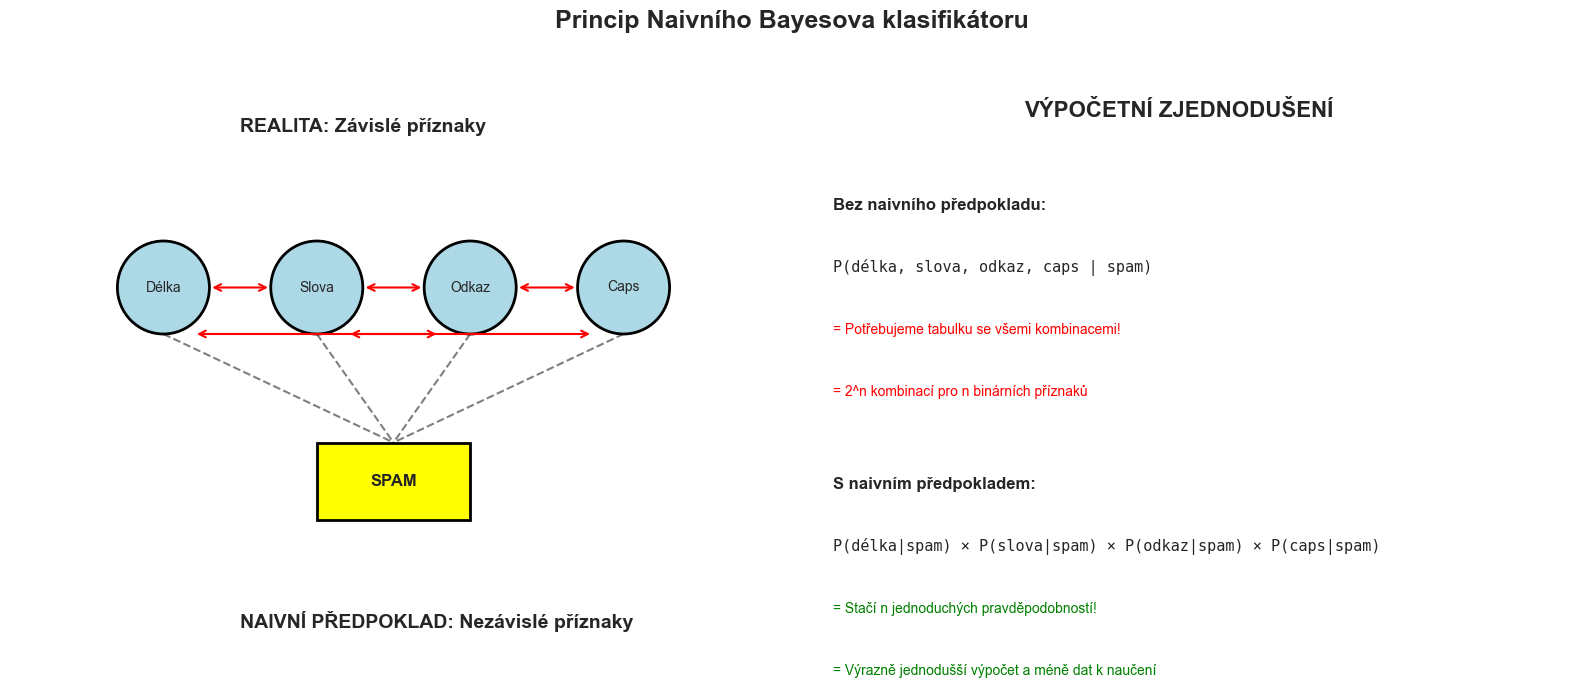

In [2]:
def visualize_naive_bayes_principle():
    """
    Vizualizace principu Naivn√≠ho Bayese na jednoduch√©m p≈ô√≠kladu
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Graf 1: Z√°visl√© vs. nez√°visl√© p≈ô√≠znaky
    ax1.set_xlim(-0.5, 5)
    ax1.set_ylim(-0.5, 4)
    
    # Z√°visl√© p≈ô√≠znaky (realita)
    ax1.text(1, 3.5, 'REALITA: Z√°visl√© p≈ô√≠znaky', fontsize=14, fontweight='bold')
    
    # Kreslen√≠ z√°vislost√≠
    features = ['D√©lka', 'Slova', 'Odkaz', 'Caps']
    positions = [(0.5, 2.5), (1.5, 2.5), (2.5, 2.5), (3.5, 2.5)]
    
    for i, (feat, pos) in enumerate(zip(features, positions)):
        circle = plt.Circle(pos, 0.3, color='lightblue', ec='black', linewidth=2)
        ax1.add_patch(circle)
        ax1.text(pos[0], pos[1], feat, ha='center', va='center', fontsize=10)
    
    # ≈†ipky zn√°zor≈àuj√≠c√≠ z√°vislosti
    dependencies = [
        ((0.8, 2.5), (1.2, 2.5)),
        ((1.8, 2.5), (2.2, 2.5)),
        ((2.8, 2.5), (3.2, 2.5)),
        ((0.7, 2.2), (2.3, 2.2)),
        ((1.7, 2.2), (3.3, 2.2))
    ]
    
    for start, end in dependencies:
        ax1.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
    
    # T≈ô√≠da
    rect = plt.Rectangle((1.5, 1), 1, 0.5, color='yellow', ec='black', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(2, 1.25, 'SPAM', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Spojnice k t≈ô√≠dƒõ
    for pos in positions:
        ax1.plot([pos[0], 2], [pos[1]-0.3, 1.5], 'k--', alpha=0.5)
    
    # Naivn√≠ p≈ôedpoklad
    ax1.text(1, 0.3, 'NAIVN√ç P≈òEDPOKLAD: Nez√°visl√© p≈ô√≠znaky', 
            fontsize=14, fontweight='bold')
    
    ax1.set_xlim(-0.5, 4.5)
    ax1.set_ylim(0, 4)
    ax1.axis('off')
    
    # Graf 2: V√Ωpoƒçetn√≠ zjednodu≈°en√≠
    ax2.text(0.5, 0.9, 'V√ùPOƒåETN√ç ZJEDNODU≈†EN√ç', 
            ha='center', fontsize=16, fontweight='bold', transform=ax2.transAxes)
    
    # Bez naivn√≠ho p≈ôedpokladu
    ax2.text(0.05, 0.75, 'Bez naivn√≠ho p≈ôedpokladu:', 
            fontsize=12, fontweight='bold', transform=ax2.transAxes)
    ax2.text(0.05, 0.65, 'P(d√©lka, slova, odkaz, caps | spam)', 
            fontsize=11, transform=ax2.transAxes, family='monospace')
    ax2.text(0.05, 0.55, '= Pot≈ôebujeme tabulku se v≈°emi kombinacemi!', 
            fontsize=10, transform=ax2.transAxes, color='red')
    ax2.text(0.05, 0.45, '= 2^n kombinac√≠ pro n bin√°rn√≠ch p≈ô√≠znak≈Ø', 
            fontsize=10, transform=ax2.transAxes, color='red')
    
    # S naivn√≠m p≈ôedpokladem
    ax2.text(0.05, 0.3, 'S naivn√≠m p≈ôedpokladem:', 
            fontsize=12, fontweight='bold', transform=ax2.transAxes)
    ax2.text(0.05, 0.2, 'P(d√©lka|spam) √ó P(slova|spam) √ó P(odkaz|spam) √ó P(caps|spam)', 
            fontsize=11, transform=ax2.transAxes, family='monospace')
    ax2.text(0.05, 0.1, '= Staƒç√≠ n jednoduch√Ωch pravdƒõpodobnost√≠!', 
            fontsize=10, transform=ax2.transAxes, color='green')
    ax2.text(0.05, 0.0, '= V√Ωraznƒõ jednodu≈°≈°√≠ v√Ωpoƒçet a m√©nƒõ dat k nauƒçen√≠', 
            fontsize=10, transform=ax2.transAxes, color='green')
    
    ax2.axis('off')
    
    plt.suptitle('Princip Naivn√≠ho Bayesova klasifik√°toru', 
                fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_naive_bayes_principle()

## 2. Matematick√Ω z√°klad

### 2.1 Odvozen√≠ klasifikaƒçn√≠ho pravidla

Pro klasifikaci hled√°me t≈ô√≠du s nejvy≈°≈°√≠ posteriorn√≠ pravdƒõpodobnost√≠:

$$\hat{y} = \arg\max_y P(y|x_1, x_2, ..., x_n)$$

Pomoc√≠ Bayesovy vƒõty a naivn√≠ho p≈ôedpokladu:

$$\hat{y} = \arg\max_y P(y) \prod_{i=1}^n P(x_i|y)$$

In [3]:
# Implementace Naivn√≠ho Bayese od z√°klad≈Ø
class NaivniBayes:
    def __init__(self):
        self.class_priors = {}
        self.feature_probs = {}
        self.classes = None
        
    def fit(self, X, y):
        """
        Nauƒçen√≠ modelu z tr√©novac√≠ch dat
        """
        self.classes = np.unique(y)
        n_samples = len(y)
        
        # V√Ωpoƒçet prior≈Ø pro ka≈ædou t≈ô√≠du
        for c in self.classes:
            mask = (y == c)
            self.class_priors[c] = np.sum(mask) / n_samples
            
            # V√Ωpoƒçet pravdƒõpodobnost√≠ p≈ô√≠znak≈Ø pro ka≈ædou t≈ô√≠du
            self.feature_probs[c] = {}
            X_class = X[mask]
            
            for feature_idx in range(X.shape[1]):
                # Pou≈æit√≠ Laplace smoothing
                feature_count = np.sum(X_class[:, feature_idx]) + 1
                total_count = len(X_class) + 2
                self.feature_probs[c][feature_idx] = feature_count / total_count
    
    def predict_proba(self, X):
        """
        V√Ωpoƒçet pravdƒõpodobnost√≠ pro ka≈ædou t≈ô√≠du
        """
        probas = []
        
        for x in X:
            class_probas = {}
            
            for c in self.classes:
                # Zaƒç√≠n√°me s priorem (pou≈æ√≠v√°me log pro numerickou stabilitu)
                log_prob = np.log(self.class_priors[c])
                
                # N√°sob√≠me pravdƒõpodobnostmi p≈ô√≠znak≈Ø
                for idx, feature_val in enumerate(x):
                    if feature_val == 1:
                        log_prob += np.log(self.feature_probs[c][idx])
                    else:
                        log_prob += np.log(1 - self.feature_probs[c][idx])
                
                class_probas[c] = np.exp(log_prob)
            
            # Normalizace
            total = sum(class_probas.values())
            class_probas = {c: p/total for c, p in class_probas.items()}
            probas.append(class_probas)
        
        return probas
    
    def predict(self, X):
        """
        Predikce t≈ô√≠dy
        """
        probas = self.predict_proba(X)
        predictions = []
        
        for proba in probas:
            predictions.append(max(proba, key=proba.get))
        
        return np.array(predictions)

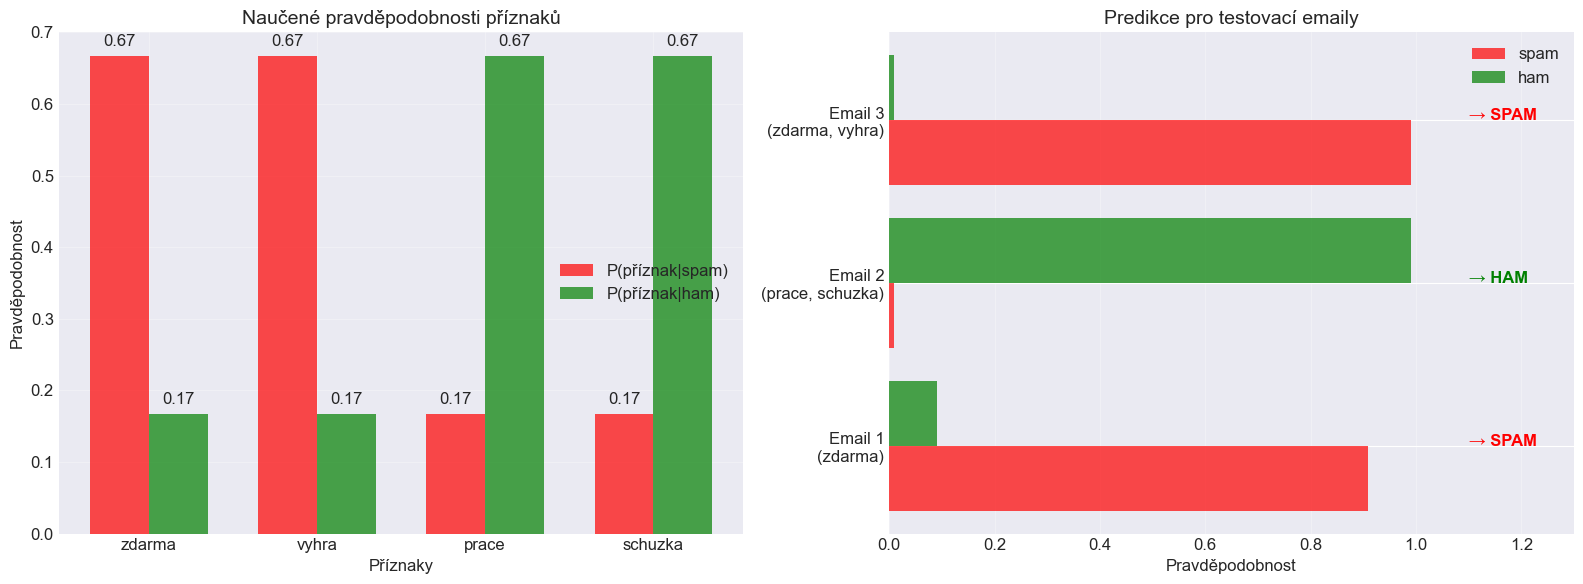

DETAILY NAIVN√çHO BAYESOVA KLASIFIK√ÅTORU

Nauƒçen√© priory:
P(spam) = 0.500
P(ham) = 0.500

Testovac√≠ predikce:

Email 1: [1 0 0 0]
Predikce: spam
P(spam|email) = 0.909
P(ham|email) = 0.091

Email 2: [0 0 1 1]
Predikce: ham
P(spam|email) = 0.010
P(ham|email) = 0.990

Email 3: [1 1 0 0]
Predikce: spam
P(spam|email) = 0.990
P(ham|email) = 0.010


In [4]:
# Uk√°zka na jednoduch√©m p≈ô√≠kladu
def simple_naive_bayes_demo():
    # Vytvo≈ôen√≠ jednoduch√©ho datasetu - emaily
    # P≈ô√≠znaky: [obsahuje "zdarma", obsahuje "vyhra", obsahuje "prace", obsahuje "schuzka"]
    X_train = np.array([
        [1, 1, 0, 0],  # spam
        [1, 0, 0, 0],  # spam
        [0, 1, 0, 0],  # spam
        [1, 1, 0, 0],  # spam
        [0, 0, 1, 1],  # ham
        [0, 0, 1, 0],  # ham
        [0, 0, 0, 1],  # ham
        [0, 0, 1, 1],  # ham
    ])
    
    y_train = np.array(['spam', 'spam', 'spam', 'spam', 'ham', 'ham', 'ham', 'ham'])
    
    # Tr√©nov√°n√≠ vlastn√≠ implementace
    nb = NaivniBayes()
    nb.fit(X_train, y_train)
    
    # Testovac√≠ data
    X_test = np.array([
        [1, 0, 0, 0],  # obsahuje "zdarma"
        [0, 0, 1, 1],  # obsahuje "prace" a "schuzka"
        [1, 1, 0, 0],  # obsahuje "zdarma" a "vyhra"
    ])
    
    # Predikce
    predictions = nb.predict(X_test)
    probabilities = nb.predict_proba(X_test)
    
    # Vizualizace v√Ωsledk≈Ø
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Graf 1: Nauƒçen√© parametry
    features = ['zdarma', 'vyhra', 'prace', 'schuzka']
    spam_probs = [nb.feature_probs['spam'][i] for i in range(4)]
    ham_probs = [nb.feature_probs['ham'][i] for i in range(4)]
    
    x = np.arange(len(features))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, spam_probs, width, label='P(p≈ô√≠znak|spam)', 
                    color='red', alpha=0.7)
    bars2 = ax1.bar(x + width/2, ham_probs, width, label='P(p≈ô√≠znak|ham)', 
                    color='green', alpha=0.7)
    
    ax1.set_ylabel('Pravdƒõpodobnost')
    ax1.set_xlabel('P≈ô√≠znaky')
    ax1.set_title('Nauƒçen√© pravdƒõpodobnosti p≈ô√≠znak≈Ø', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(features)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # P≈ôid√°n√≠ hodnot
    for bars, probs in [(bars1, spam_probs), (bars2, ham_probs)]:
        for bar, prob in zip(bars, probs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.2f}', ha='center', va='bottom')
    
    # Graf 2: V√Ωsledky predikce
    test_labels = ['Email 1\n(zdarma)', 'Email 2\n(prace, schuzka)', 'Email 3\n(zdarma, vyhra)']
    
    for i, (label, pred, probs) in enumerate(zip(test_labels, predictions, probabilities)):
        spam_prob = probs.get('spam', 0)
        ham_prob = probs.get('ham', 0)
        
        ax2.barh(i*2, spam_prob, color='red', alpha=0.7, label='spam' if i == 0 else '')
        ax2.barh(i*2+0.8, ham_prob, color='green', alpha=0.7, label='ham' if i == 0 else '')
        
        # Oznaƒçen√≠ predikce
        ax2.text(1.1, i*2+0.4, f'‚Üí {pred.upper()}', fontsize=12, fontweight='bold',
                color='red' if pred == 'spam' else 'green')
    
    ax2.set_yticks([0.4, 2.4, 4.4])
    ax2.set_yticklabels(test_labels)
    ax2.set_xlabel('Pravdƒõpodobnost')
    ax2.set_title('Predikce pro testovac√≠ emaily', fontsize=14)
    ax2.legend()
    ax2.set_xlim(0, 1.3)
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # V√Ωpis detail≈Ø
    print("="*60)
    print("DETAILY NAIVN√çHO BAYESOVA KLASIFIK√ÅTORU")
    print("="*60)
    print(f"\nNauƒçen√© priory:")
    print(f"P(spam) = {nb.class_priors['spam']:.3f}")
    print(f"P(ham) = {nb.class_priors['ham']:.3f}")
    
    print("\nTestovac√≠ predikce:")
    for i, (features, pred, probs) in enumerate(zip(X_test, predictions, probabilities)):
        print(f"\nEmail {i+1}: {features}")
        print(f"Predikce: {pred}")
        print(f"P(spam|email) = {probs.get('spam', 0):.3f}")
        print(f"P(ham|email) = {probs.get('ham', 0):.3f}")

simple_naive_bayes_demo()

## 3. Varianty Naivn√≠ho Bayese

### 3.1 Podle typu dat

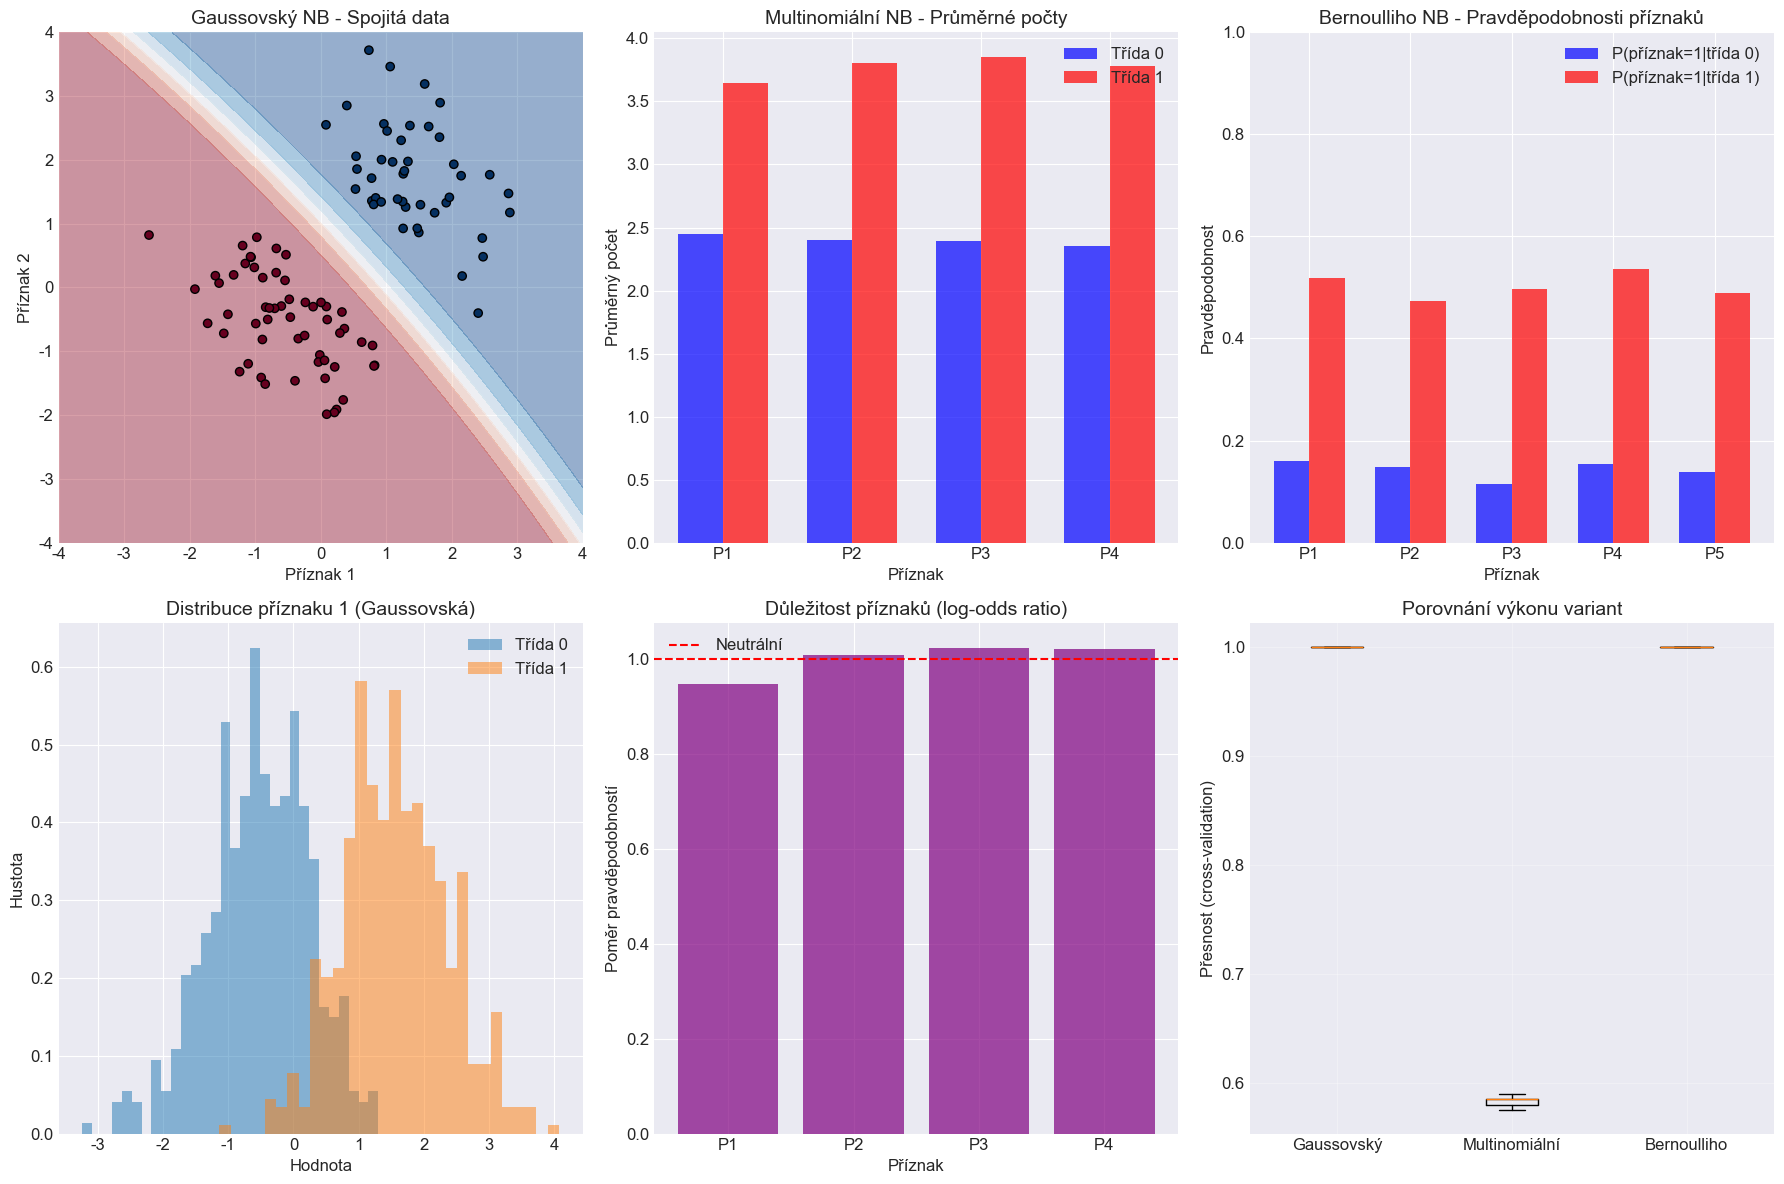

VARIANTY NAIVN√çHO BAYESOVA KLASIFIK√ÅTORU

1. GAUSSOVSK√ù NB:
   - Pro spojit√© p≈ô√≠znaky
   - P≈ôedpokl√°d√° norm√°ln√≠ rozdƒõlen√≠
   - Vhodn√Ω pro: v√Ω≈°ka, v√°ha, teplota, atd.

2. MULTINOMI√ÅLN√ç NB:
   - Pro diskr√©tn√≠ poƒçty
   - Modeluje ƒçetnosti v√Ωskytu
   - Vhodn√Ω pro: poƒçty slov v textu, frekvence

3. BERNOULLIHO NB:
   - Pro bin√°rn√≠ p≈ô√≠znaky
   - Modeluje p≈ô√≠tomnost/nep≈ô√≠tomnost
   - Vhodn√Ω pro: bin√°rn√≠ p≈ô√≠znaky, p≈ô√≠tomnost slov


In [5]:
# Demonstrace r≈Øzn√Ωch variant Naivn√≠ho Bayese
def demonstrate_naive_bayes_variants():
    # Generov√°n√≠ r≈Øzn√Ωch typ≈Ø dat
    np.random.seed(42)
    n_samples = 1000
    
    # 1. Gaussovsk√° data (spojit√°)
    X_gaussian = np.random.randn(n_samples, 2)
    y_gaussian = (X_gaussian[:, 0] + X_gaussian[:, 1] > 0).astype(int)
    X_gaussian[y_gaussian == 1] += [1, 1]
    
    # 2. Multinomi√°ln√≠ data (poƒçty)
    X_multinomial = np.random.poisson(3, size=(n_samples, 4))
    y_multinomial = (X_multinomial.sum(axis=1) > 12).astype(int)
    
    # 3. Bernoulliho data (bin√°rn√≠)
    X_bernoulli = np.random.binomial(1, 0.3, size=(n_samples, 5))
    y_bernoulli = (X_bernoulli.sum(axis=1) >= 2).astype(int)
    
    # Vizualizace
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Gaussovsk√Ω NB
    gnb = GaussianNB()
    gnb.fit(X_gaussian, y_gaussian)
    
    # Vizualizace rozhodovac√≠ hranice
    xx, yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
    Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    axes[0, 0].contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    axes[0, 0].scatter(X_gaussian[:100, 0], X_gaussian[:100, 1], 
                      c=y_gaussian[:100], cmap='RdBu', edgecolors='black')
    axes[0, 0].set_title('Gaussovsk√Ω NB - Spojit√° data', fontsize=14)
    axes[0, 0].set_xlabel('P≈ô√≠znak 1')
    axes[0, 0].set_ylabel('P≈ô√≠znak 2')
    
    # Distribuce p≈ô√≠znak≈Ø pro Gaussovsk√Ω NB
    for class_idx in [0, 1]:
        mask = y_gaussian == class_idx
        axes[1, 0].hist(X_gaussian[mask, 0], bins=30, alpha=0.5, 
                       label=f'T≈ô√≠da {class_idx}', density=True)
    
    axes[1, 0].set_title('Distribuce p≈ô√≠znaku 1 (Gaussovsk√°)', fontsize=14)
    axes[1, 0].set_xlabel('Hodnota')
    axes[1, 0].set_ylabel('Hustota')
    axes[1, 0].legend()
    
    # Multinomi√°ln√≠ NB
    mnb = MultinomialNB()
    mnb.fit(X_multinomial, y_multinomial)
    
    # Pr≈Ømƒõrn√© poƒçty pro ka≈ædou t≈ô√≠du
    mean_counts = []
    for class_idx in [0, 1]:
        mask = y_multinomial == class_idx
        mean_counts.append(X_multinomial[mask].mean(axis=0))
    
    x = np.arange(4)
    width = 0.35
    
    bars1 = axes[0, 1].bar(x - width/2, mean_counts[0], width, 
                          label='T≈ô√≠da 0', color='blue', alpha=0.7)
    bars2 = axes[0, 1].bar(x + width/2, mean_counts[1], width, 
                          label='T≈ô√≠da 1', color='red', alpha=0.7)
    
    axes[0, 1].set_title('Multinomi√°ln√≠ NB - Pr≈Ømƒõrn√© poƒçty', fontsize=14)
    axes[0, 1].set_xlabel('P≈ô√≠znak')
    axes[0, 1].set_ylabel('Pr≈Ømƒõrn√Ω poƒçet')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([f'P{i+1}' for i in range(4)])
    axes[0, 1].legend()
    
    # Feature importance pro Multinomi√°ln√≠ NB
    feature_log_prob = mnb.feature_log_prob_
    importance = np.exp(feature_log_prob[1] - feature_log_prob[0])
    
    axes[1, 1].bar(x, importance, color='purple', alpha=0.7)
    axes[1, 1].axhline(y=1, color='red', linestyle='--', label='Neutr√°ln√≠')
    axes[1, 1].set_title('D≈Øle≈æitost p≈ô√≠znak≈Ø (log-odds ratio)', fontsize=14)
    axes[1, 1].set_xlabel('P≈ô√≠znak')
    axes[1, 1].set_ylabel('Pomƒõr pravdƒõpodobnost√≠')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels([f'P{i+1}' for i in range(4)])
    axes[1, 1].legend()
    
    # Bernoulliho NB
    bnb = BernoulliNB()
    bnb.fit(X_bernoulli, y_bernoulli)
    
    # Pravdƒõpodobnosti p≈ô√≠znak≈Ø
    feature_probs = np.exp(bnb.feature_log_prob_)
    
    x = np.arange(5)
    bars1 = axes[0, 2].bar(x - width/2, feature_probs[0], width, 
                          label='P(p≈ô√≠znak=1|t≈ô√≠da 0)', color='blue', alpha=0.7)
    bars2 = axes[0, 2].bar(x + width/2, feature_probs[1], width, 
                          label='P(p≈ô√≠znak=1|t≈ô√≠da 1)', color='red', alpha=0.7)
    
    axes[0, 2].set_title('Bernoulliho NB - Pravdƒõpodobnosti p≈ô√≠znak≈Ø', fontsize=14)
    axes[0, 2].set_xlabel('P≈ô√≠znak')
    axes[0, 2].set_ylabel('Pravdƒõpodobnost')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels([f'P{i+1}' for i in range(5)])
    axes[0, 2].legend()
    axes[0, 2].set_ylim(0, 1)
    
    # V√Ωkon r≈Øzn√Ωch variant
    variants = [
        ('Gaussovsk√Ω', gnb, X_gaussian, y_gaussian),
        ('Multinomi√°ln√≠', mnb, X_multinomial, y_multinomial),
        ('Bernoulliho', bnb, X_bernoulli, y_bernoulli)
    ]
    
    scores = []
    for name, model, X, y in variants:
        cv_scores = cross_val_score(model, X, y, cv=5)
        scores.append(cv_scores)
    
    axes[1, 2].boxplot(scores, labels=[v[0] for v in variants])
    axes[1, 2].set_title('Porovn√°n√≠ v√Ωkonu variant', fontsize=14)
    axes[1, 2].set_ylabel('P≈ôesnost (cross-validation)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Shrnut√≠
    print("="*70)
    print("VARIANTY NAIVN√çHO BAYESOVA KLASIFIK√ÅTORU")
    print("="*70)
    print("\n1. GAUSSOVSK√ù NB:")
    print("   - Pro spojit√© p≈ô√≠znaky")
    print("   - P≈ôedpokl√°d√° norm√°ln√≠ rozdƒõlen√≠")
    print("   - Vhodn√Ω pro: v√Ω≈°ka, v√°ha, teplota, atd.")
    
    print("\n2. MULTINOMI√ÅLN√ç NB:")
    print("   - Pro diskr√©tn√≠ poƒçty")
    print("   - Modeluje ƒçetnosti v√Ωskytu")
    print("   - Vhodn√Ω pro: poƒçty slov v textu, frekvence")
    
    print("\n3. BERNOULLIHO NB:")
    print("   - Pro bin√°rn√≠ p≈ô√≠znaky")
    print("   - Modeluje p≈ô√≠tomnost/nep≈ô√≠tomnost")
    print("   - Vhodn√Ω pro: bin√°rn√≠ p≈ô√≠znaky, p≈ô√≠tomnost slov")

demonstrate_naive_bayes_variants()

## 4. Spam filtr - kompletn√≠ implementace

### 4.1 P≈ô√≠prava dat

In [6]:
# Vytvo≈ôen√≠ datasetu email≈Ø
def create_email_dataset():
    # Simulace emailov√Ωch dat
    spam_emails = [
        "Vyhrajte penize zdarma! Kliknete zde ihned!",
        "Gratulujeme! Vyhr√°li jste 1 milion Kƒç! Volejte nyn√≠!",
        "Speci√°ln√≠ nab√≠dka pouze dnes! Sleva 90% na v≈°echno!",
        "ZDARMA ZDARMA ZDARMA! Objednejte si n√°≈° produkt!",
        "Rychl√© pen√≠ze! Vydƒõl√°vejte tis√≠ce dennƒõ z domova!",
        "Tato nab√≠dka vypr≈°√≠ za 24 hodin! Jednejte rychle!",
        "Kliknƒõte zde pro okam≈æit√© schv√°len√≠ √∫vƒõru!",
        "Sta≈àte se milion√°≈ôem bƒõhem t√Ωdne! 100% zaruƒçeno!",
        "Exkluzivn√≠ nab√≠dka jen pro v√°s! Omezenƒõ!",
        "POZOR! V√°≈° √∫ƒçet bude zru≈°en! Kliknƒõte pro obnoven√≠!"
    ] * 10  # Zvƒõt≈°√≠me dataset
    
    ham_emails = [
        "Dobr√Ω den, pos√≠l√°m v√°m report z minul√©ho t√Ωdne.",
        "Sch≈Øzka je napl√°nov√°na na z√≠tra v 10:00.",
        "Dƒõkuji za v√°≈° email. Odpov√≠m co nejd≈ô√≠ve.",
        "Projekt postupuje podle pl√°nu. Dokumentace je p≈ôilo≈æena.",
        "M≈Ø≈æeme se sej√≠t p≈ô√≠≈°t√≠ t√Ωden ohlednƒõ nov√© zak√°zky?",
        "P≈ôepos√≠l√°m informace z porady. Pros√≠m o koment√°≈ôe.",
        "Rozpoƒçet na p≈ô√≠≈°t√≠ kvart√°l je v p≈ô√≠loze.",
        "T√Ωm dokonƒçil implementaci nov√© funkcionality.",
        "Pros√≠m o schv√°len√≠ n√°sleduj√≠c√≠ch zmƒõn v projektu.",
        "Z√≠tra budu pracovat z domova. Jsem dostupn√Ω na telefonu."
    ] * 10
    
    # Kombinace a oznaƒçen√≠
    emails = spam_emails + ham_emails
    labels = ['spam'] * len(spam_emails) + ['ham'] * len(ham_emails)
    
    # Zam√≠ch√°n√≠
    indices = np.random.permutation(len(emails))
    emails = [emails[i] for i in indices]
    labels = [labels[i] for i in indices]
    
    return emails, labels

# P≈ôedzpracov√°n√≠ textu
def preprocess_text(text):
    # P≈ôevod na mal√° p√≠smena
    text = text.lower()
    # Odstranƒõn√≠ interpunkce
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Odstranƒõn√≠ ƒç√≠slic
    text = re.sub(r'\d+', '', text)
    # Odstranƒõn√≠ extra mezer
    text = ' '.join(text.split())
    return text

# Vytvo≈ôen√≠ datasetu
emails, labels = create_email_dataset()
print(f"Vytvo≈ôeno {len(emails)} email≈Ø ({labels.count('spam')} spam, {labels.count('ham')} ham)")
print("\nUk√°zka email≈Ø:")
print("SPAM:", emails[labels.index('spam')])
print("HAM:", emails[labels.index('ham')])

Vytvo≈ôeno 200 email≈Ø (100 spam, 100 ham)

Uk√°zka email≈Ø:
SPAM: Exkluzivn√≠ nab√≠dka jen pro v√°s! Omezenƒõ!
HAM: Dobr√Ω den, pos√≠l√°m v√°m report z minul√©ho t√Ωdne.


### 4.2 Implementace spam filtru

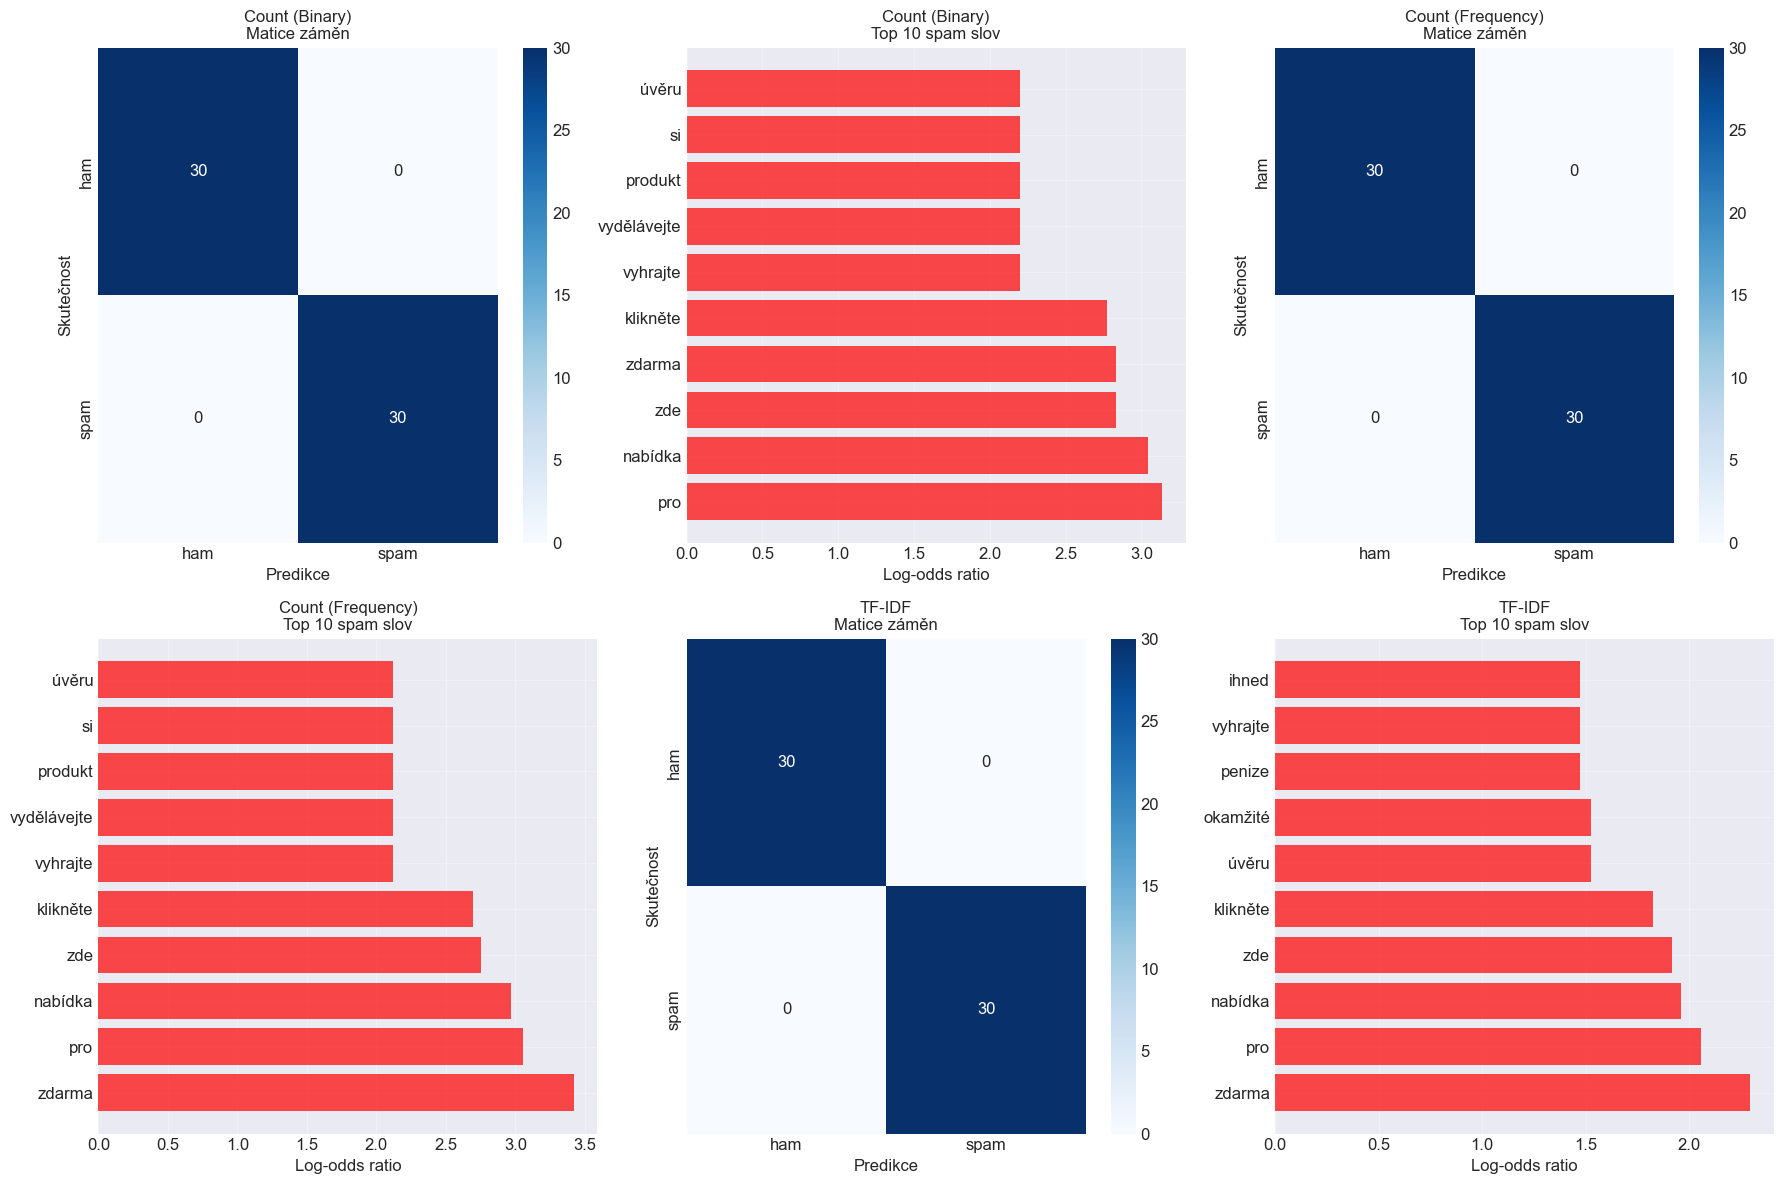

V√ùSLEDKY SPAM FILTRU

Count (Binary):
  P≈ôesnost: 100.00%

Klasifikaƒçn√≠ report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00        30
        spam       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


Count (Frequency):
  P≈ôesnost: 100.00%

Klasifikaƒçn√≠ report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00        30
        spam       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


TF-IDF:
  P≈ôesnost: 100.00%

Klasifikaƒçn√≠ report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00        30
        spam       1.00      1.00 

In [7]:
# Kompletn√≠ spam filtr s r≈Øzn√Ωmi p≈ô√≠stupy
def build_spam_filter():
    # Z√≠sk√°n√≠ dat
    emails, labels = create_email_dataset()
    
    # P≈ôedzpracov√°n√≠
    processed_emails = [preprocess_text(email) for email in emails]
    
    # Rozdƒõlen√≠ na tr√©novac√≠ a testovac√≠
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        processed_emails, labels, test_size=0.3, random_state=42, stratify=labels
    )
    
    # R≈Øzn√© zp≈Øsoby vektorizace
    vectorizers = {
        'Count (Binary)': CountVectorizer(binary=True, max_features=100),
        'Count (Frequency)': CountVectorizer(binary=False, max_features=100),
        'TF-IDF': TfidfVectorizer(max_features=100)
    }
    
    results = {}
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, (vec_name, vectorizer) in enumerate(vectorizers.items()):
        # Vektorizace
        X_train = vectorizer.fit_transform(X_train_text)
        X_test = vectorizer.transform(X_test_text)
        
        # V√Ωbƒõr vhodn√©ho NB klasifik√°toru
        if vec_name == 'Count (Binary)':
            clf = BernoulliNB()
        elif vec_name == 'TF-IDF':
            clf = MultinomialNB()  # TF-IDF values are non-negative
        else:
            clf = MultinomialNB()
        
        # Tr√©nov√°n√≠
        clf.fit(X_train, y_train)
        
        # Predikce
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Ulo≈æen√≠ v√Ωsledk≈Ø
        results[vec_name] = {
            'vectorizer': vectorizer,
            'classifier': clf,
            'accuracy': accuracy,
            'predictions': y_pred
        }
        
        # Matice z√°mƒõn
        cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])
        
        # Vizualizace matice z√°mƒõn
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['ham', 'spam'],
                   yticklabels=['ham', 'spam'],
                   ax=axes[idx*2])
        axes[idx*2].set_title(f'{vec_name}\nMatice z√°mƒõn', fontsize=12)
        axes[idx*2].set_ylabel('Skuteƒçnost')
        axes[idx*2].set_xlabel('Predikce')
        
        # Top slova pro spam
        if hasattr(clf, 'feature_log_prob_'):
            feature_names = vectorizer.get_feature_names_out()
            
            # Log-odds ratio pro spam vs ham
            log_odds = clf.feature_log_prob_[1] - clf.feature_log_prob_[0]
            indices = np.argsort(log_odds)[::-1]
            
            # Top 10 spam slov
            top_spam_indices = indices[:10]
            top_spam_words = [feature_names[i] for i in top_spam_indices]
            top_spam_scores = [log_odds[i] for i in top_spam_indices]
            
            axes[idx*2+1].barh(range(10), top_spam_scores, color='red', alpha=0.7)
            axes[idx*2+1].set_yticks(range(10))
            axes[idx*2+1].set_yticklabels(top_spam_words)
            axes[idx*2+1].set_xlabel('Log-odds ratio')
            axes[idx*2+1].set_title(f'{vec_name}\nTop 10 spam slov', fontsize=12)
            axes[idx*2+1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Souhrn v√Ωsledk≈Ø
    print("="*70)
    print("V√ùSLEDKY SPAM FILTRU")
    print("="*70)
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"  P≈ôesnost: {res['accuracy']:.2%}")
        
        # Klasifikaƒçn√≠ report
        print("\nKlasifikaƒçn√≠ report:")
        print(classification_report(y_test, res['predictions'], 
                                  target_names=['ham', 'spam']))
    
    return results

# Spu≈°tƒõn√≠ spam filtru
spam_filter_results = build_spam_filter()

### 4.3 Testov√°n√≠ na nov√Ωch emailech

Pou≈æ√≠v√°m nejlep≈°√≠ model: Count (Binary) (p≈ôesnost: 100.00%)


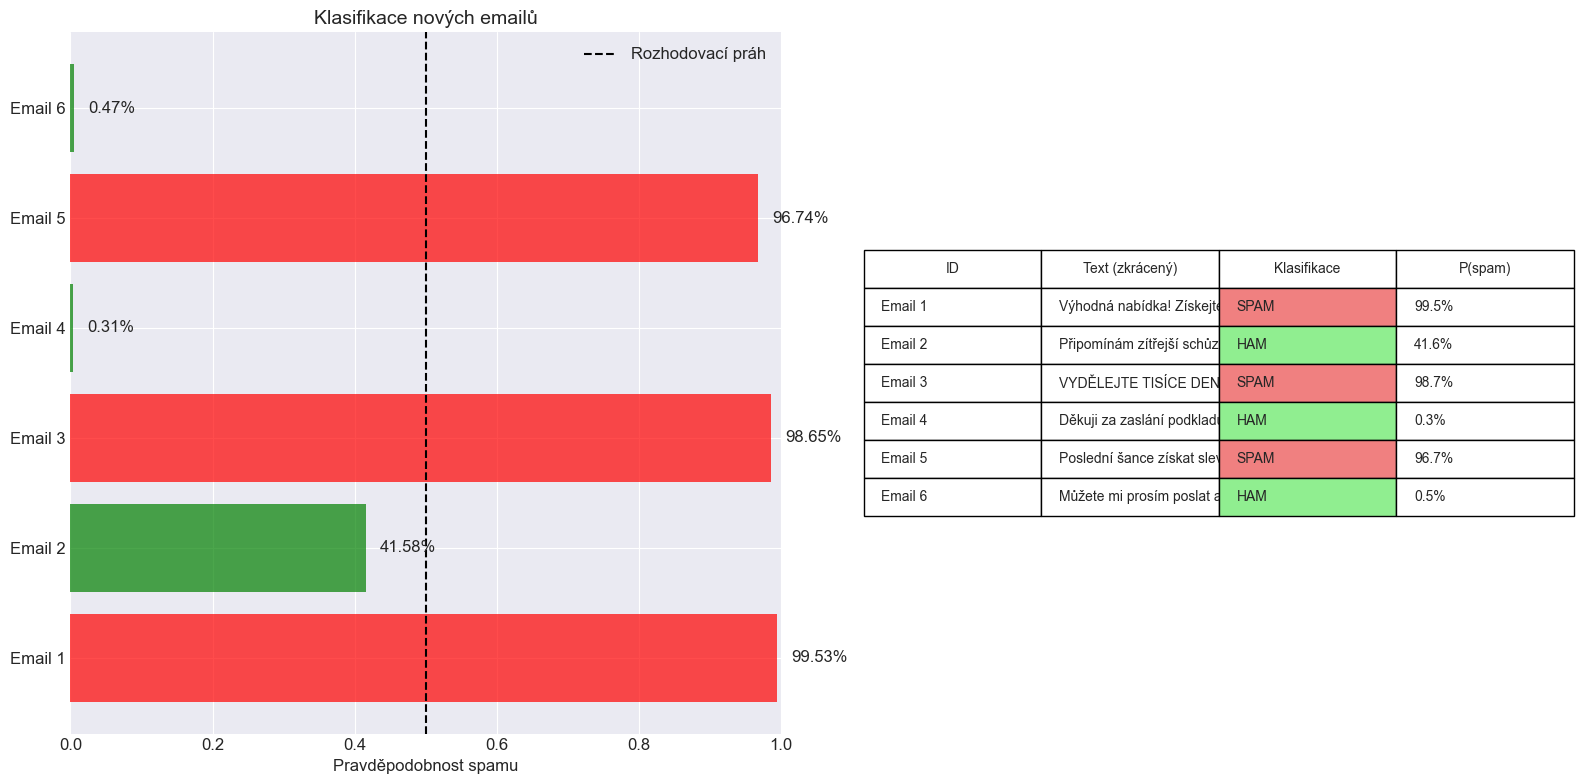


DETAILN√ç KLASIFIKACE

Email 1: V√Ωhodn√° nab√≠dka! Z√≠skejte √∫vƒõr ihned bez ruƒçitele!
Klasifikace: SPAM
Pravdƒõpodobnost spamu: 99.53%
D≈Øvƒõra v klasifikaci: 99.53%

Email 2: P≈ôipom√≠n√°m z√≠t≈ôej≈°√≠ sch≈Øzku v 14:00 v zasedac√≠ m√≠stnosti.
Klasifikace: HAM
Pravdƒõpodobnost spamu: 41.58%
D≈Øvƒõra v klasifikaci: 58.42%

Email 3: VYDƒöLEJTE TIS√çCE DENNƒö! Pracujte z domova!
Klasifikace: SPAM
Pravdƒõpodobnost spamu: 98.65%
D≈Øvƒõra v klasifikaci: 98.65%

Email 4: Dƒõkuji za zasl√°n√≠ podklad≈Ø. Projdu je a ozvu se.
Klasifikace: HAM
Pravdƒõpodobnost spamu: 0.31%
D≈Øvƒõra v klasifikaci: 99.69%

Email 5: Posledn√≠ ≈°ance z√≠skat slevu 80%! Pouze dnes!
Klasifikace: SPAM
Pravdƒõpodobnost spamu: 96.74%
D≈Øvƒõra v klasifikaci: 96.74%

Email 6: M≈Ø≈æete mi pros√≠m poslat aktualizovan√Ω rozpoƒçet?
Klasifikace: HAM
Pravdƒõpodobnost spamu: 0.47%
D≈Øvƒõra v klasifikaci: 99.53%


In [8]:
# Funkce pro klasifikaci nov√Ωch email≈Ø
def classify_new_emails(results):
    # V√Ωbƒõr nejlep≈°√≠ho modelu
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    best_model = results[best_model_name]
    
    print(f"Pou≈æ√≠v√°m nejlep≈°√≠ model: {best_model_name} (p≈ôesnost: {best_model['accuracy']:.2%})")
    
    # Nov√© testovac√≠ emaily
    new_emails = [
        "V√Ωhodn√° nab√≠dka! Z√≠skejte √∫vƒõr ihned bez ruƒçitele!",
        "P≈ôipom√≠n√°m z√≠t≈ôej≈°√≠ sch≈Øzku v 14:00 v zasedac√≠ m√≠stnosti.",
        "VYDƒöLEJTE TIS√çCE DENNƒö! Pracujte z domova!",
        "Dƒõkuji za zasl√°n√≠ podklad≈Ø. Projdu je a ozvu se.",
        "Posledn√≠ ≈°ance z√≠skat slevu 80%! Pouze dnes!",
        "M≈Ø≈æete mi pros√≠m poslat aktualizovan√Ω rozpoƒçet?"
    ]
    
    # Klasifikace
    vectorizer = best_model['vectorizer']
    classifier = best_model['classifier']
    
    processed_new = [preprocess_text(email) for email in new_emails]
    X_new = vectorizer.transform(processed_new)
    
    predictions = classifier.predict(X_new)
    probabilities = classifier.predict_proba(X_new)
    
    # Vizualizace v√Ωsledk≈Ø
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Graf 1: Pravdƒõpodobnosti pro ka≈æd√Ω email
    email_labels = [f"Email {i+1}" for i in range(len(new_emails))]
    spam_probs = probabilities[:, 1]  # Pravdƒõpodobnost spamu
    
    colors = ['red' if pred == 'spam' else 'green' for pred in predictions]
    bars = ax1.barh(email_labels, spam_probs, color=colors, alpha=0.7)
    
    ax1.axvline(x=0.5, color='black', linestyle='--', label='Rozhodovac√≠ pr√°h')
    ax1.set_xlabel('Pravdƒõpodobnost spamu')
    ax1.set_title('Klasifikace nov√Ωch email≈Ø', fontsize=14)
    ax1.set_xlim(0, 1)
    ax1.legend()
    
    # P≈ôid√°n√≠ hodnot
    for bar, prob in zip(bars, spam_probs):
        width = bar.get_width()
        ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f'{prob:.2%}', ha='left', va='center')
    
    # Graf 2: Detaily email≈Ø
    ax2.axis('tight')
    ax2.axis('off')
    
    # Vytvo≈ôen√≠ tabulky s v√Ωsledky
    table_data = []
    for i, (email, pred, prob) in enumerate(zip(new_emails, predictions, spam_probs)):
        # Zkr√°cen√≠ emailu pro zobrazen√≠
        short_email = email[:50] + '...' if len(email) > 50 else email
        table_data.append([
            f"Email {i+1}",
            short_email,
            pred.upper(),
            f"{prob:.1%}"
        ])
    
    table = ax2.table(cellText=table_data,
                     colLabels=['ID', 'Text (zkr√°cen√Ω)', 'Klasifikace', 'P(spam)'],
                     cellLoc='left',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Obarven√≠ podle klasifikace
    for i in range(1, len(table_data) + 1):
        if predictions[i-1] == 'spam':
            table[(i, 2)].set_facecolor('lightcoral')
        else:
            table[(i, 2)].set_facecolor('lightgreen')
    
    plt.tight_layout()
    plt.show()
    
    # Detailn√≠ v√Ωpis
    print("\n" + "="*70)
    print("DETAILN√ç KLASIFIKACE")
    print("="*70)
    for i, (email, pred, prob) in enumerate(zip(new_emails, predictions, spam_probs)):
        print(f"\nEmail {i+1}: {email}")
        print(f"Klasifikace: {pred.upper()}")
        print(f"Pravdƒõpodobnost spamu: {prob:.2%}")
        print(f"D≈Øvƒõra v klasifikaci: {max(prob, 1-prob):.2%}")

# Test nov√Ωch email≈Ø
classify_new_emails(spam_filter_results)

## 5. Anal√Ωza sentimentu

### 5.1 Implementace anal√Ωzy sentimentu

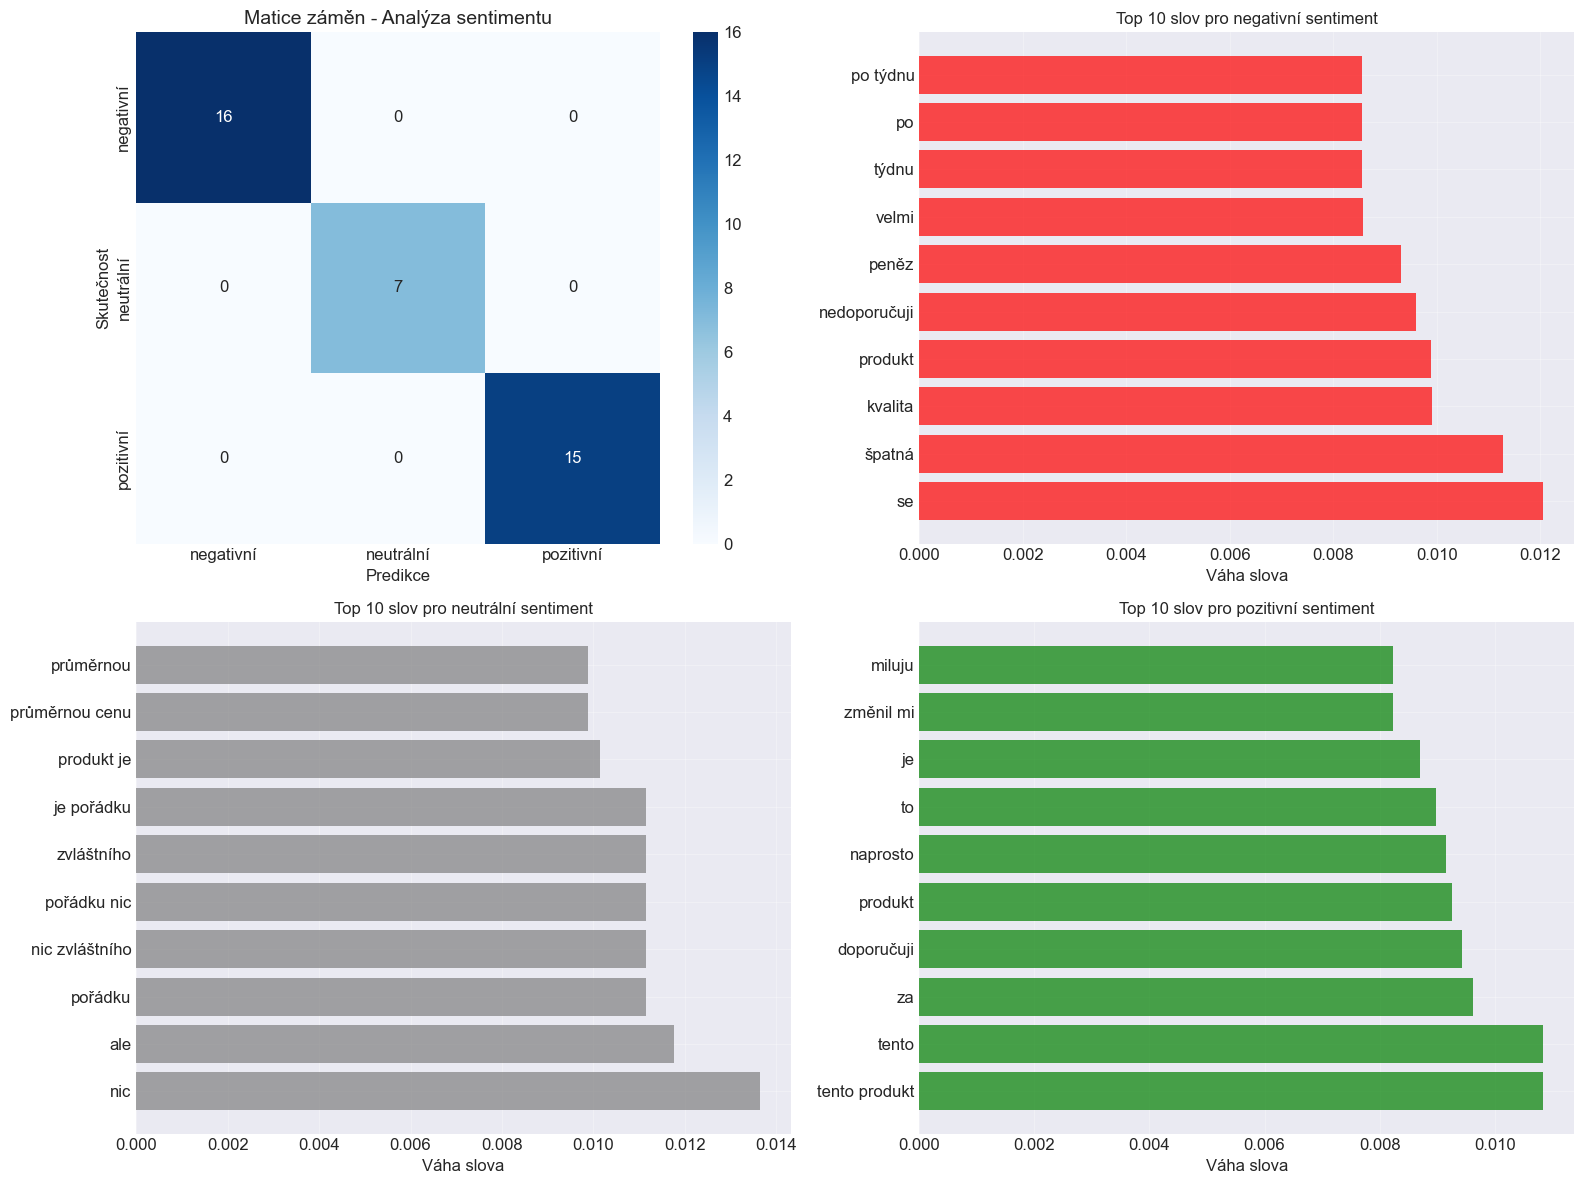

V√ùSLEDKY ANAL√ùZY SENTIMENTU

Celkov√° p≈ôesnost: 100.00%

Klasifikaƒçn√≠ report:
              precision    recall  f1-score   support

   negativn√≠       1.00      1.00      1.00        16
   neutr√°ln√≠       1.00      1.00      1.00         7
   pozitivn√≠       1.00      1.00      1.00        15

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [9]:
# Vytvo≈ôen√≠ datasetu pro anal√Ωzu sentimentu
def create_sentiment_dataset():
    # Pozitivn√≠ recenze
    positive_reviews = [
        "Tento produkt je naprosto √∫≈æasn√Ω! Velmi doporuƒçuji!",
        "Skvƒõl√° kvalita za rozumnou cenu. Jsem velmi spokojen√Ω.",
        "P≈ôekonal moje oƒçek√°v√°n√≠. Funguje perfektnƒõ!",
        "Nejlep≈°√≠ n√°kup za posledn√≠ dobu. Dƒõkuji!",
        "V√Ωborn√Ω produkt, rychl√© dod√°n√≠. Super zku≈°enost.",
        "Naprosto spokojen√Ω z√°kazn√≠k. Budu kupovat znovu.",
        "Kvalita je fantastick√°. Stoj√≠ to za ka≈ædou korunu.",
        "Miluju tento produkt! Zmƒõnil mi ≈æivot.",
        "Profesion√°ln√≠ p≈ô√≠stup a skvƒõl√Ω v√Ωsledek.",
        "Doporuƒçuji v≈°em! Nem√° to chybu."
    ] * 5
    
    # Negativn√≠ recenze
    negative_reviews = [
        "Zklam√°n√≠. Produkt nefunguje jak m√°.",
        "≈†patn√° kvalita. Rozbilo se po t√Ωdnu.",
        "Nejhor≈°√≠ n√°kup ever. Vyhozen√© pen√≠ze.",
        "Nedoporuƒçuji. Velmi ≈°patn√° zku≈°enost.",
        "Produkt neodpov√≠d√° popisu. C√≠t√≠m se podveden.",
        "Hrozn√° kvalita za p≈ôemr≈°tƒõnou cenu.",
        "Nefunkƒçn√≠ produkt. ≈Ω√°d√°m o vr√°cen√≠ penƒõz.",
        "Katastrofa. U≈æ nikdy v√≠ce od t√©to firmy.",
        "Ztr√°ta ƒçasu a penƒõz. Velmi zklam√°n.",
        "Nedoporuƒçuji nikomu. Absolutn√≠ propad√°k."
    ] * 5
    
    # Neutr√°ln√≠ recenze
    neutral_reviews = [
        "Produkt je v po≈ô√°dku. Nic zvl√°≈°tn√≠ho.",
        "Spl≈àuje √∫ƒçel, ale nic v√≠c.",
        "Pr≈Ømƒõrn√° kvalita za pr≈Ømƒõrnou cenu.",
        "Funguje jak m√°, ale nejsem nad≈°en√Ω.",
        "Standardn√≠ produkt bez p≈ôekvapen√≠."
    ] * 5
    
    # Kombinace
    reviews = positive_reviews + negative_reviews + neutral_reviews
    sentiments = (['pozitivn√≠'] * len(positive_reviews) + 
                 ['negativn√≠'] * len(negative_reviews) + 
                 ['neutr√°ln√≠'] * len(neutral_reviews))
    
    # Zam√≠ch√°n√≠
    indices = np.random.permutation(len(reviews))
    reviews = [reviews[i] for i in indices]
    sentiments = [sentiments[i] for i in indices]
    
    return reviews, sentiments

# Anal√Ωza sentimentu s vizualizac√≠
def sentiment_analysis():
    # Z√≠sk√°n√≠ dat
    reviews, sentiments = create_sentiment_dataset()
    
    # P≈ôedzpracov√°n√≠
    processed_reviews = [preprocess_text(review) for review in reviews]
    
    # Rozdƒõlen√≠ dat
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        processed_reviews, sentiments, test_size=0.3, random_state=42
    )
    
    # Vektorizace s n-gramy
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=200)
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)
    
    # Tr√©nov√°n√≠ modelu
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    
    # Predikce
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    # Vizualizace
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Matice z√°mƒõn
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=clf.classes_,
               yticklabels=clf.classes_,
               ax=ax1)
    ax1.set_title('Matice z√°mƒõn - Anal√Ωza sentimentu', fontsize=14)
    ax1.set_ylabel('Skuteƒçnost')
    ax1.set_xlabel('Predikce')
    
    # 2. D≈Øle≈æitost slov pro ka≈ædou t≈ô√≠du
    feature_names = vectorizer.get_feature_names_out()
    
    # Pro ka≈ædou t≈ô√≠du najdeme top slova
    for i, sentiment in enumerate(clf.classes_):
        class_idx = list(clf.classes_).index(sentiment)
        feature_scores = clf.feature_log_prob_[class_idx]
        top_indices = np.argsort(feature_scores)[-10:][::-1]
        top_words = [feature_names[idx] for idx in top_indices]
        top_scores = [feature_scores[idx] for idx in top_indices]
        
        # Normalizace pro lep≈°√≠ vizualizaci
        top_scores = np.exp(top_scores)
        
        ax = [ax2, ax3, ax4][i]
        colors = ['red' if sentiment == 'negativn√≠' else 
                 'green' if sentiment == 'pozitivn√≠' else 'gray']
        
        ax.barh(range(10), top_scores, color=colors[0], alpha=0.7)
        ax.set_yticks(range(10))
        ax.set_yticklabels(top_words)
        ax.set_xlabel('V√°ha slova')
        ax.set_title(f'Top 10 slov pro {sentiment} sentiment', fontsize=12)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # V√Ωsledky
    print("="*70)
    print("V√ùSLEDKY ANAL√ùZY SENTIMENTU")
    print("="*70)
    print(f"\nCelkov√° p≈ôesnost: {accuracy_score(y_test, y_pred):.2%}")
    print("\nKlasifikaƒçn√≠ report:")
    print(classification_report(y_test, y_pred))
    
    return clf, vectorizer

# Spu≈°tƒõn√≠ anal√Ωzy sentimentu
sentiment_clf, sentiment_vec = sentiment_analysis()

### 5.2 Test na nov√Ωch recenz√≠ch

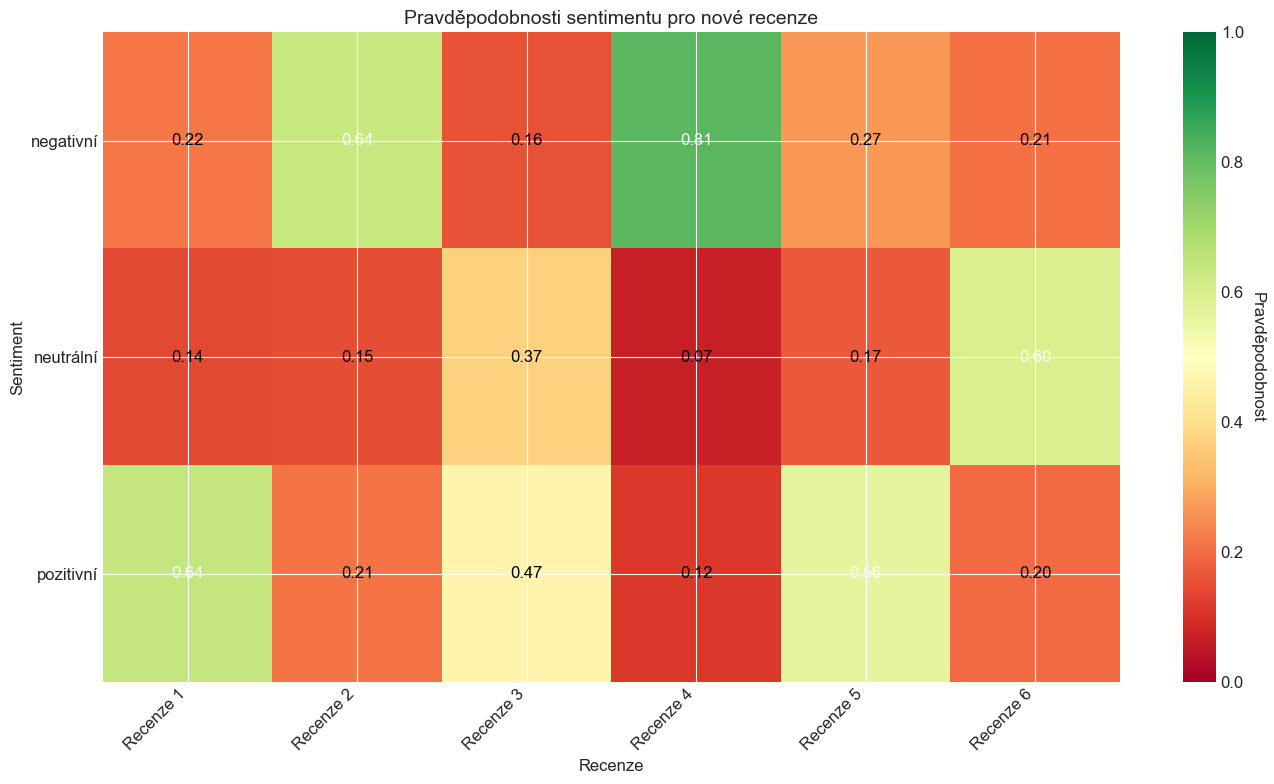

ANAL√ùZA SENTIMENTU NOV√ùCH RECENZ√ç

Recenze 1: Absolutnƒõ fantastick√Ω produkt! P≈ôekonal v≈°echna oƒçek√°v√°n√≠!
Predikovan√Ω sentiment: POZITIVN√ç
Pravdƒõpodobnosti:
  negativn√≠: 21.68%
  neutr√°ln√≠: 14.26%
  pozitivn√≠: 64.06%
D≈Øvƒõra: 64.06%

Recenze 2: Tot√°ln√≠ zklam√°n√≠. Nefunguje v≈Øbec.
Predikovan√Ω sentiment: NEGATIVN√ç
Pravdƒõpodobnosti:
  negativn√≠: 63.52%
  neutr√°ln√≠: 15.00%
  pozitivn√≠: 21.48%
D≈Øvƒõra: 63.52%

Recenze 3: Je to OK, nic moc, ale ujde to.
Predikovan√Ω sentiment: POZITIVN√ç
Pravdƒõpodobnosti:
  negativn√≠: 15.76%
  neutr√°ln√≠: 37.48%
  pozitivn√≠: 46.76%
D≈Øvƒõra: 46.76%

Recenze 4: Velmi ≈°patn√° kvalita. Nedoporuƒçuji.
Predikovan√Ω sentiment: NEGATIVN√ç
Pravdƒõpodobnosti:
  negativn√≠: 81.42%
  neutr√°ln√≠: 7.03%
  pozitivn√≠: 11.55%
D≈Øvƒõra: 81.42%

Recenze 5: Skvƒõl√Ω pomƒõr cena/v√Ωkon. Spokojenost.
Predikovan√Ω sentiment: POZITIVN√ç
Pravdƒõpodobnosti:
  negativn√≠: 26.75%
  neutr√°ln√≠: 16.87%
  pozitivn√≠: 56.38%
D≈Øvƒõra: 56.38%

Recenze 

In [10]:
# Test sentimentu na nov√Ωch recenz√≠ch
def test_sentiment_analysis(clf, vectorizer):
    new_reviews = [
        "Absolutnƒõ fantastick√Ω produkt! P≈ôekonal v≈°echna oƒçek√°v√°n√≠!",
        "Tot√°ln√≠ zklam√°n√≠. Nefunguje v≈Øbec.",
        "Je to OK, nic moc, ale ujde to.",
        "Velmi ≈°patn√° kvalita. Nedoporuƒçuji.",
        "Skvƒõl√Ω pomƒõr cena/v√Ωkon. Spokojenost.",
        "Pr≈Ømƒõrn√Ω produkt za pr≈Ømƒõrnou cenu."
    ]
    
    # P≈ôedzpracov√°n√≠ a predikce
    processed = [preprocess_text(review) for review in new_reviews]
    X_new = vectorizer.transform(processed)
    predictions = clf.predict(X_new)
    probabilities = clf.predict_proba(X_new)
    
    # Vizualizace v√Ωsledk≈Ø
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Heatmapa pravdƒõpodobnost√≠
    prob_matrix = probabilities.T
    
    im = ax.imshow(prob_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Nastaven√≠ os
    ax.set_xticks(range(len(new_reviews)))
    ax.set_xticklabels([f'Recenze {i+1}' for i in range(len(new_reviews))], 
                      rotation=45, ha='right')
    ax.set_yticks(range(len(clf.classes_)))
    ax.set_yticklabels(clf.classes_)
    
    # P≈ôid√°n√≠ hodnot do bunƒõk
    for i in range(len(clf.classes_)):
        for j in range(len(new_reviews)):
            text = ax.text(j, i, f'{prob_matrix[i, j]:.2f}',
                          ha='center', va='center',
                          color='white' if prob_matrix[i, j] > 0.5 else 'black')
    
    ax.set_title('Pravdƒõpodobnosti sentimentu pro nov√© recenze', fontsize=14)
    ax.set_ylabel('Sentiment')
    ax.set_xlabel('Recenze')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Pravdƒõpodobnost', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    # Detailn√≠ v√Ωpis
    print("="*80)
    print("ANAL√ùZA SENTIMENTU NOV√ùCH RECENZ√ç")
    print("="*80)
    for i, (review, pred, probs) in enumerate(zip(new_reviews, predictions, probabilities)):
        print(f"\nRecenze {i+1}: {review}")
        print(f"Predikovan√Ω sentiment: {pred.upper()}")
        print("Pravdƒõpodobnosti:")
        for j, class_name in enumerate(clf.classes_):
            print(f"  {class_name}: {probs[j]:.2%}")
        print(f"D≈Øvƒõra: {max(probs):.2%}")

# Test nov√Ωch recenz√≠
test_sentiment_analysis(sentiment_clf, sentiment_vec)

## 6. Interaktivn√≠ aplikace

### 6.1 Gradio aplikace pro spam filtr a anal√Ωzu sentimentu

In [ ]:
# Interaktivn√≠ aplikace
def create_naive_bayes_app():
    # P≈ô√≠prava model≈Ø
    # Spam filtr
    emails, labels = create_email_dataset()
    spam_vec = TfidfVectorizer(max_features=100)
    X_spam = spam_vec.fit_transform([preprocess_text(e) for e in emails])
    spam_clf = MultinomialNB()
    spam_clf.fit(X_spam, labels)
    
    # Sentiment analyzer
    reviews, sentiments = create_sentiment_dataset()
    sent_vec = TfidfVectorizer(ngram_range=(1, 2), max_features=200)
    X_sent = sent_vec.fit_transform([preprocess_text(r) for r in reviews])
    sent_clf = MultinomialNB()
    sent_clf.fit(X_sent, sentiments)
    
    def analyze_text(text, analysis_type):
        processed = preprocess_text(text)
        
        if analysis_type == "Spam Filter":
            X = spam_vec.transform([processed])
            clf = spam_clf
            vec = spam_vec
            classes = ['ham', 'spam']
            title = "Spam Analysis"
        else:
            X = sent_vec.transform([processed])
            clf = sent_clf
            vec = sent_vec
            classes = list(clf.classes_)
            title = "Sentiment Analysis"
        
        # Predikce
        prediction = clf.predict(X)[0]
        probabilities = clf.predict_proba(X)[0]
        
        # Vytvo≈ôen√≠ grafu
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Graf 1: Pravdƒõpodobnosti
        colors = ['green' if c == 'ham' or c == 'pozitivn√≠' else 
                 'red' if c == 'spam' or c == 'negativn√≠' else 
                 'gray' for c in classes]
        
        bars = ax1.bar(classes, probabilities, color=colors, alpha=0.7)
        ax1.set_ylim(0, 1)
        ax1.set_ylabel('Pravdƒõpodobnost')
        ax1.set_title(f'{title} - V√Ωsledky', fontsize=14)
        
        # P≈ôid√°n√≠ hodnot
        for bar, prob in zip(bars, probabilities):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{prob:.2%}', ha='center', va='bottom')
        
        # Graf 2: D≈Øle≈æit√° slova
        # Z√≠sk√°n√≠ p≈ô√≠znak≈Ø textu
        feature_names = vec.get_feature_names_out()
        tfidf_scores = X.toarray()[0]
        
        # Nenulov√© p≈ô√≠znaky
        nonzero_indices = np.where(tfidf_scores > 0)[0]
        if len(nonzero_indices) > 0:
            words = [feature_names[i] for i in nonzero_indices]
            scores = [tfidf_scores[i] for i in nonzero_indices]
            
            # Se≈ôazen√≠ podle d≈Øle≈æitosti
            sorted_indices = np.argsort(scores)[::-1][:10]
            top_words = [words[i] for i in sorted_indices]
            top_scores = [scores[i] for i in sorted_indices]
            
            ax2.barh(range(len(top_words)), top_scores, color='steelblue', alpha=0.7)
            ax2.set_yticks(range(len(top_words)))
            ax2.set_yticklabels(top_words)
            ax2.set_xlabel('TF-IDF sk√≥re')
            ax2.set_title('D≈Øle≈æit√° slova v textu', fontsize=14)
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, '≈Ω√°dn√° v√Ωznamn√° slova nenalezena',
                    ha='center', va='center', fontsize=12)
            ax2.axis('off')
        
        plt.tight_layout()
        
        # Textov√Ω v√Ωstup
        result_text = f"""## V√Ωsledky anal√Ωzy

**Typ anal√Ωzy:** {analysis_type}
**Predikce:** {prediction.upper()}
**D≈Øvƒõra:** {max(probabilities):.1%}

### Pravdƒõpodobnosti:
"""
        for class_name, prob in zip(classes, probabilities):
            result_text += f"- {class_name}: {prob:.2%}\n"
        
        if analysis_type == "Spam Filter":
            if prediction == 'spam':
                result_text += "\n‚ö†Ô∏è **Varov√°n√≠:** Tento text byl klasifikov√°n jako SPAM!"
            else:
                result_text += "\n‚úÖ **OK:** Tento text vypad√° jako legitimn√≠ zpr√°va."
        else:
            emoji = "üòä" if prediction == 'pozitivn√≠' else "üòû" if prediction == 'negativn√≠' else "üòê"
            result_text += f"\n{emoji} **Sentiment:** {prediction.capitalize()}"
        
        return fig, result_text
    
    # Vytvo≈ôen√≠ Gradio interface
    with gr.Blocks(title="Naivn√≠ Bayes Analyzer") as demo:
        gr.Markdown("# ü§ñ Naivn√≠ Bayes≈Øv klasifik√°tor")
        gr.Markdown("""Analyzujte text pomoc√≠ Naivn√≠ho Bayesova klasifik√°toru.
        M≈Ø≈æete detekovat spam nebo analyzovat sentiment textu.""")
        
        with gr.Row():
            with gr.Column():
                text_input = gr.Textbox(
                    label="Zadejte text k anal√Ωze",
                    placeholder="Ahoj, bavili jsme se naposledy na sch≈Øzce o nƒõjak√© t√© akci ke Dn≈Øm AI, p≈ô√≠padnƒõ k T√Ωdnu inovac√≠, ≈æe by ses mohl spolu√∫ƒçastnit. Romƒça ƒåern√≠kov√° je krajsk√Ωm koordin√°torem ke Dn≈Øm AI a pr√Ω ses nƒõkam registroval, tak ti psala e-mail. M≈Ø≈æu j√≠ d√°t Tvoje tel. ƒç√≠slo, a≈• se spoj√≠te, nebo j√≠ odpov√≠≈° na e-mail?",
                    lines=5
                )
                
                analysis_type = gr.Radio(
                    choices=["Spam Filter", "Sentiment Analysis"],
                    value="Spam Filter",
                    label="Typ anal√Ωzy"
                )
                
                analyze_btn = gr.Button("üîç Analyzovat", variant="primary")
                
                # P≈ô√≠klady
                gr.Examples(
                    examples=[
                        ["Vyhrajte milion korun! Kliknƒõte zde pro v√≠ce informac√≠!", "Spam Filter"],
                        ["Dƒõkuji za v√°≈° email. Odpov√≠m co nejd≈ô√≠ve.", "Spam Filter"],
                        ["Tento produkt je absolutnƒõ skvƒõl√Ω! Velmi doporuƒçuji!", "Sentiment Analysis"],
                        ["Zklam√°n√≠. Produkt v≈Øbec nefunguje.", "Sentiment Analysis"]
                    ],
                    inputs=[text_input, analysis_type]
                )
            
            with gr.Column():
                output_text = gr.Markdown("### V√Ωsledky se zobraz√≠ zde...")
        
        output_plot = gr.Plot(label="Vizualizace")
        
        analyze_btn.click(
            analyze_text,
            inputs=[text_input, analysis_type],
            outputs=[output_plot, output_text]
        )
        
        gr.Markdown("""### üìö O Naivn√≠m Bayesovƒõ klasifik√°toru
        
Naivn√≠ Bayes≈Øv klasifik√°tor je pravdƒõpodobnostn√≠ klasifik√°tor zalo≈æen√Ω na Bayesovƒõ vƒõtƒõ
s "naivn√≠m" p≈ôedpokladem nez√°vislosti mezi p≈ô√≠znaky. I p≈ôes tento zjednodu≈°uj√≠c√≠ p≈ôedpoklad
dosahuje ƒçasto velmi dobr√Ωch v√Ωsledk≈Ø, zejm√©na p≈ôi:

- **Klasifikaci textu** (spam filtrov√°n√≠, anal√Ωza sentimentu)
- **Kategorizaci dokument≈Ø**
- **Predikci s omezen√Ωmi daty**

**V√Ωhody:**
- Rychl√© uƒçen√≠ a predikce
- Funguje dob≈ôe i s m√°lo daty
- Poskytuje pravdƒõpodobnosti pro ka≈ædou t≈ô√≠du
- Odoln√Ω v≈Øƒçi irelevantn√≠m p≈ô√≠znak≈Øm
        """)
    
    return demo

# Spu≈°tƒõn√≠ aplikace
app = create_naive_bayes_app()
app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://7317f84e2d606b3149.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7. Shrnut√≠ a kl√≠ƒçov√© koncepty

### Co jsme se nauƒçili:

1. **Princip Naivn√≠ho Bayese**
   - Zalo≈æen na Bayesovƒõ vƒõtƒõ
   - "Naivn√≠" p≈ôedpoklad nez√°vislosti p≈ô√≠znak≈Ø
   - V√Ωpoƒçetnƒõ efektivn√≠

2. **Varianty podle typu dat**
   - **Gaussovsk√Ω NB** - spojit√© p≈ô√≠znaky
   - **Multinomi√°ln√≠ NB** - poƒçty/frekvence
   - **Bernoulliho NB** - bin√°rn√≠ p≈ô√≠znaky

3. **Praktick√© aplikace**
   - Spam filtrov√°n√≠
   - Anal√Ωza sentimentu
   - Klasifikace dokument≈Ø

4. **V√Ωhody a nev√Ωhody**
   - ‚úÖ Rychl√Ω a efektivn√≠
   - ‚úÖ Funguje i s m√°lo daty
   - ‚úÖ Poskytuje pravdƒõpodobnosti
   - ‚ùå P≈ôedpoklad nez√°vislosti ƒçasto nerealistick√Ω
   - ‚ùå M≈Ø≈æe b√Ωt p≈ô√≠li≈° jednoduch√Ω pro komplexn√≠ data

## 8. Dom√°c√≠ √∫kol

### √ökol 1: Vylep≈°en√Ω spam filtr
Roz≈°i≈ôte spam filtr o:
- Detekci velk√Ωch p√≠smen (CAPS)
- Poƒçet v√Ωk≈ôiƒçn√≠k≈Ø
- D√©lku emailu
- P≈ô√≠tomnost URL

### √ökol 2: V√≠cejazyƒçn√° anal√Ωza sentimentu
Implementujte anal√Ωzu sentimentu, kter√°:
- Detekuje jazyk textu
- Pou≈æ√≠v√° odpov√≠daj√≠c√≠ model
- Vizualizuje v√Ωsledky

### √ökol 3: Porovn√°n√≠ s jin√Ωmi klasifik√°tory
Porovnejte Naivn√≠ Bayes s:
- Logistickou regres√≠
- Rozhodovac√≠m stromem
- SVM
Na stejn√Ωch datech a vizualizujte rozd√≠ly

### Bonusov√Ω √∫kol: Real-time klasifik√°tor
Vytvo≈ôte aplikaci, kter√°:
- Klasifikuje text bƒõhem psan√≠
- Zobrazuje pravdƒõpodobnosti v re√°ln√©m ƒçase
- Uƒç√≠ se z oprav u≈æivatele

---

üí° **Tip**: Naivn√≠ Bayes je skvƒõl√Ω zaƒç√°tek pro klasifikaci textu. Experimentujte s r≈Øzn√Ωmi zp≈Øsoby p≈ôedzpracov√°n√≠ a v√Ωbƒõru p≈ô√≠znak≈Ø!